# Cross-Validation

In [4]:
library(caret)
set.seed(1)
draw.data <- function(n) {
    x <- rnorm(n)
    y <- 2+x-2*x^2 + rnorm(n)
    return(data.frame(x=x,y=y))
}
data <- draw.data(150)
true.test.data <- draw.data(1000)

## Validation Set
We begin by using the validation set approach to estimate the test statistics for various linear models.

First, split the data into a training and a validation set:

In [37]:
trainIdx <- createDataPartition(data$y,p=0.8,list=FALSE)
training.set <- data[trainIdx,]
validation.set <- data[-trainIdx,]

In [38]:
estimate.models <- function(training.set) {
    models <- list()
    models$lm1 <- lm(y~poly(x,1),data=training.set)
    models$lm2 <- lm(y~poly(x,2),data=training.set)
    models$lm3 <- lm(y~poly(x,3),data=training.set)
    models$lm4 <- lm(y~poly(x,4),data=training.set)
    models$lm5 <- lm(y~poly(x,5),data=training.set)
    return(models)
}
estimate.mse <- function(model,data.set) {
    mean((predict(model,newdata=data.set)-data.set$y)^2)
}

In [39]:
models <- estimate.models(training.set)

In [40]:
testMSE.VS <- numeric(length(models))
true.testMSE <- numeric(length(models))
for(i in seq_along(models)) {
    model <- models[[i]]
    testMSE.VS[i] <- estimate.mse(model,validation.set)
    true.testMSE[i] <- estimate.mse(model,true.test.data)
}

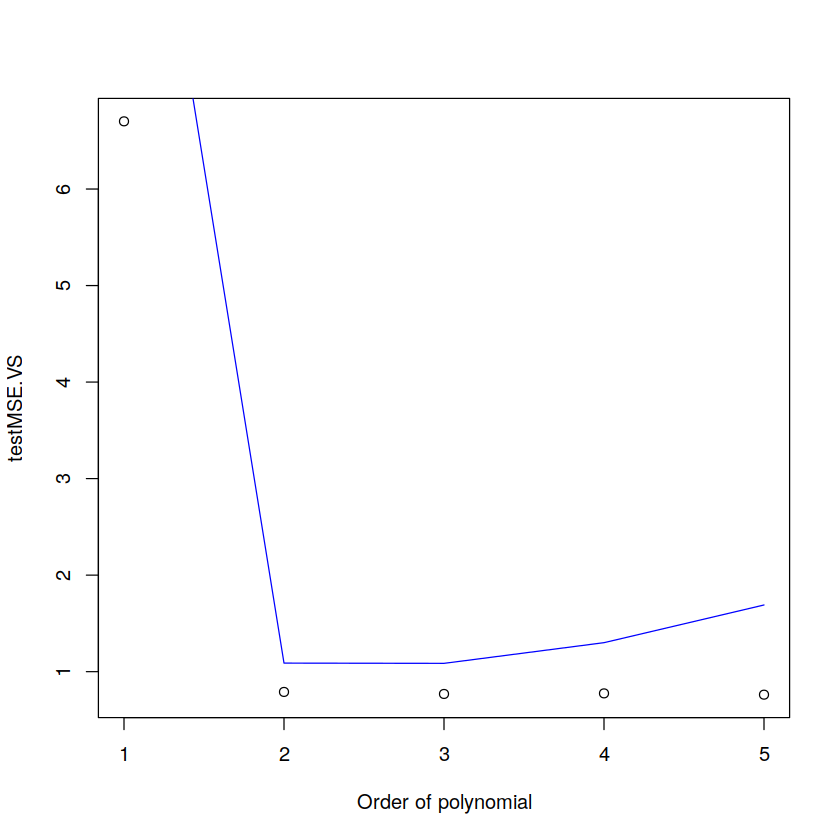

In [41]:
plot(testMSE.VS,xlab="Order of polynomial")
lines(true.testMSE,col="blue")